In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def readImages(index):
    l = []
    diry = 'image_mosaicing/'
    for img in os.listdir(diry):
        if img[3]==str(index):
            i = cv2.imread(diry+img)
            i = cv2.cvtColor(i,cv2.COLOR_BGR2RGB)
            l.append(i)
    return np.asarray(l)

In [3]:
def resize(images,scale_percent):
    new =[]
    for img in images:
        width = int(img.shape[1] * scale_percent / 100)
        height = int(img.shape[0] * scale_percent / 100)
        dim = (width, height)
        resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
        new.append(resized)
    return np.asarray(new)

## Feature Matching
We make keypoints using ORB and then match features using both flann and brute force., FLANN builds an efficient data structure (KD-Tree) that will be used to search for an approximate neighbour, while cv::BFMatcher does an exhaustive search and is guaranteed to find the best neighbour. The real benefit of FLANN is seen with large data sets.

In [4]:
def keypoints(image,disp=False):
    orb = cv2.ORB_create(nfeatures=1000)
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    keypoints,descriptors = orb.detectAndCompute(gray, None)
    key = np.int32([kp.pt for kp in keypoints])
    if disp:
        return keypoints,key,descriptors
    else:
        return key,descriptors

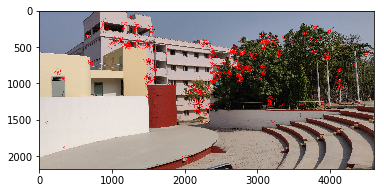

In [7]:
# Example of keypoints
l1 = readImages(1)
key,kp1,ds1 = keypoints(l1[0],disp=True)
img2 = cv2.drawKeypoints(l1[0],key,None,(255,0,0),4)
plt.imshow(img2)

In [19]:
# Flann Matching
def feature_matching(kp1,kp2,ds1,ds2,test_ratio=0.3):
    FLANN_INDEX_LSH = 6
    index_params= dict(algorithm = FLANN_INDEX_LSH,
                   table_number = 6, # 12
                   key_size = 12,     # 20
                   multi_probe_level = 1) #2

    search_params = dict(checks=200)
    flann = cv2.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(ds1,ds2,k=2)
# #     As per Lowe's paper
    refined_matches = []
    for i,m in enumerate(matches):
        if m[0].distance < test_ratio*m[1].distance and len(m)==2:
            refined_matches.append((m[0].queryIdx, m[0].trainIdx))

    match1, match2 = [], []
    for id1, id2 in refined_matches:
        match1.append(kp1[id1])
        match2.append(kp2[id2])
    return np.int32(match1),np.int32(match2)

In [38]:
def match_keypoints(keypoints_A, keypoints_B, features_A, features_B, test_ratio):
    matcher = cv2.DescriptorMatcher_create("BruteForce")
    matches = matcher.knnMatch(features_A, features_B, 2)

    refined_matches = []
    for m in matches:
        if len(m) == 2 and m[0].distance < m[1].distance * test_ratio:
            refined_matches.append((m[0].queryIdx, m[0].trainIdx))

    match_A, match_B = [], []
    for idA, idB in refined_matches:
        match_A.append(keypoints_A[idA])
        match_B.append(keypoints_B[idB])

    return np.int32(match_A), np.int32(match_B)


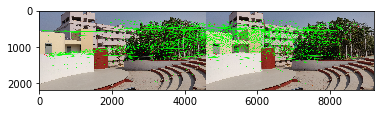

In [10]:
# m,img = feature_matching(l1,kp1,ds1,0)
# plt.imshow(img)

## Homography Matrix
We have keypoints between images and we want to calculate the homography matrix. In order to do that we take any 4 points, compute the homography matrix, project the points from image A onto image B and then calculate the reprojection error. We do this using RANSAC algorithm where in we perform this operation for N times to make it robust. N is chosen such that the probability of having atleast one inlier is 0.99.

In [66]:
def DLT(match1, match2):
    assert match1.shape[0] == match2.shape[0]

    A = np.zeros((match1.shape[0]*2, 9))
    i = 0
    total = zip(match1, match2)
    for ip, wp in total:
        u, v = ip
        x, y = wp
        A[2*i] = [0, 0, 0, -u, -v, -1, u*y, v*y, y]
        A[2*i+1] = [u, v, 1, 0, 0, 0, -u*x, -v*x, -x]
        i+=1

    # Solving using SVD
    u_, D, v_T = np.linalg.svd(A)
    v_T[-1] = v_T[-1]/v_T[-1, -1]
    H = np.reshape(v_T[-1], (3, 3))
    return H
        

In [102]:
def projectError(H, matches_A, matches_B):
    errors = []

    matches_A = np.pad(matches_A, ((0, 0), (0, 1)), 'constant', constant_values=1)
    matches_B = np.pad(matches_B, ((0, 0), (0, 1)), 'constant', constant_values=1)
    
    try:
        H_inv = np.linalg.inv(H)
    except np.linalg.LinAlgError:
        return False, 0

    A_ = (H@matches_A.T).T
    A_ = A_[:, :2] / A_[:, -1].reshape(matches_A.shape[0], 1)
    d1 = np.linalg.norm(A_[:, :2] - matches_B[:, :2], ord=2, axis=1)

    B_ = (H_inv@matches_B.T).T
    B_ = B_ / B_[:, -1].reshape(matches_B.shape[0], 1)
    d2 = np.linalg.norm(B_[:, :2] - matches_A[:, :2], ord=2, axis=1)

    outliers = np.nonzero(d1+d2 > 0.5)[0]

    return True, len(outliers)

In [97]:
def makeHomography(matches_A, matches_B, ransac_iters):
    n_points = matches_A.shape[0]

    best_Homo = None
    min_error = np.inf
    for i in range(ransac_iters):
        indices = np.int32(np.random.permutation(n_points))

        X, Y = matches_A[indices[0:4]], matches_B[indices[0:4]]
        X_test, Y_test = matches_A[indices[4::]], matches_B[indices[4::]]

        homography = DLT(X, Y)
        res, error = projectError(homography, X_test, Y_test)
        if not res:
            continue

        if error < min_error:
            min_error = error
            best_Homo = homography

    return best_Homo, min_error

## Warping Images
Once we get homography matrix, we project the image onto the other images plane and stitch them together 

In [121]:
def warp_project(imageA, imageB, homography):
    h1, w1,c1 = imageA.shape
    h2, w2,c2 = imageB.shape
    pts1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
    pts2 = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)
    pts2_ = cv2.perspectiveTransform(pts2, homography)
    pts = np.concatenate((pts1, pts2_), axis=0)
    xmin, ymin = np.int32(pts.min(axis=0).reshape(-1) - 0.5)
    xmax, ymax = np.int32(pts.max(axis=0).reshape(-1) + 0.5)
    diff = (xmax-xmin, ymax-ymin)
    t = [-xmin, -ymin]
    Ht = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]])

    result = cv2.warpPerspective(imageB, Ht@homography, diff)
    result[t[1]:h1+t[1], t[0]:w1+t[0]] = imageA
    return result

In [122]:
def stitch(image1, image2, brute,test_ratio=0.75, N=10000,):
    k1,d1 = keypoints(image1)
    k2,d2 = keypoints(image2)
    if brute:
        m1,m2 = match_keypoints(k1,k2,d1,d2,test_ratio)
    else:
        m1,m2 = feature_matching(k1,k2,d1,d2,test_ratio)
    homography, error = makeHomography(m1,m2, N)
    stitched_image = warp_project(image2, image1, homography)

    return stitched_image


In [123]:
def stitchAll(images,brute):
    res = images[0]
    i=0
    for img in images[1:]:
        plt.imshow(res)
        plt.show()
        res = stitch(res,img,brute)  
        i +=1
    return res

## Experiments

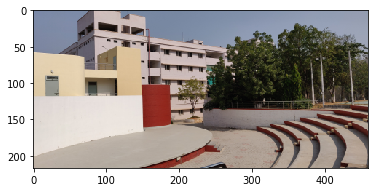

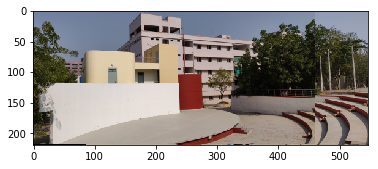

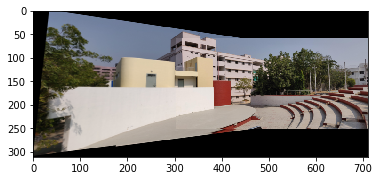

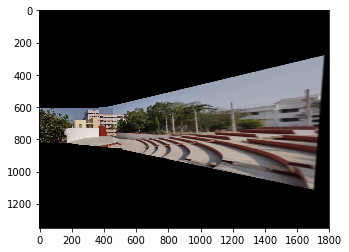

In [134]:
images = readImages(1)
images = resize(images,10)
s = stitchAll(images,False)
plt.imshow(s)
plt.show()

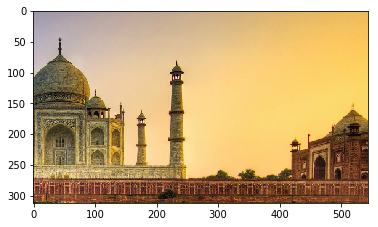

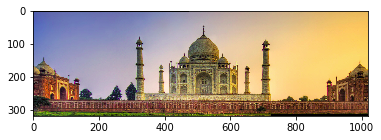

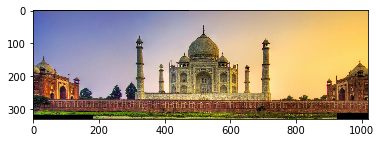

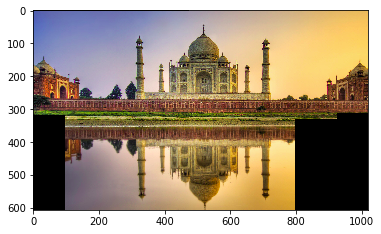

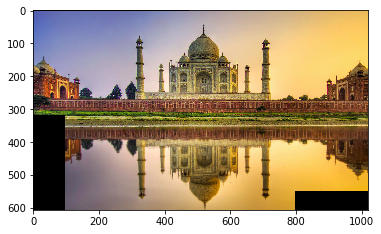

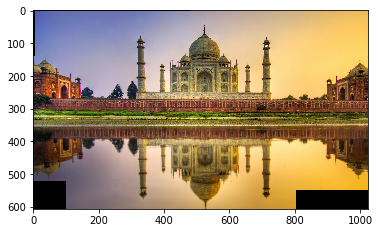

In [126]:
images = readImages(2)
# images = resize(images,10)
s = stitchAll(images,True)
plt.imshow(s)
plt.show()

In this example we see that its able to stitch seamlessly due to no rotation between images so the homography matrix is a simple cut. For some reason flann is unable to work 

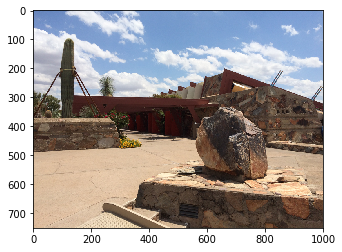

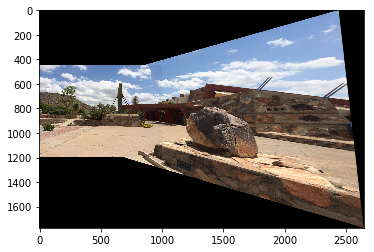

In [130]:
images = readImages(3)
# images = resize(images,10)
s = stitchAll(images,False)
plt.imshow(s)
plt.show()

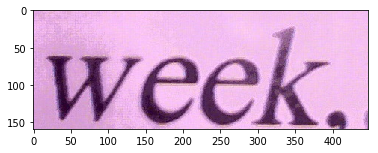

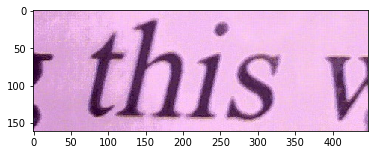

In [133]:
images = readImages(4)
# images = resize(images,10)
s = stitchAll(images,False)
plt.imshow(s)
plt.show()

In the last example we observe that very few matches are there, thus its unable to stitch. If we lower the threshold then it maybe able to stitch.

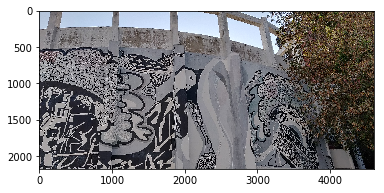

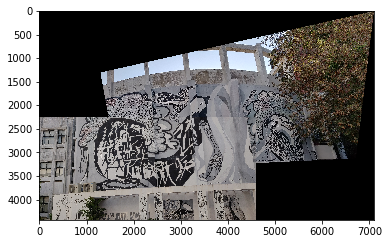

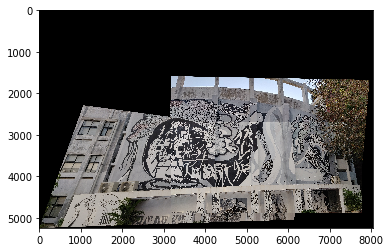

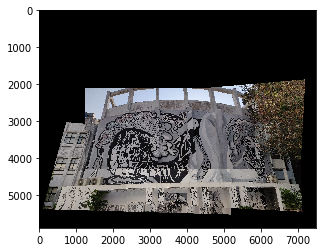

In [137]:
images = readImages(5)
# images = resize(images,10)
s = stitchAll(images,False)
plt.imshow(s)
plt.show()

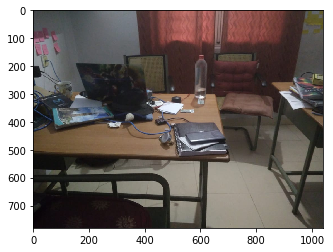

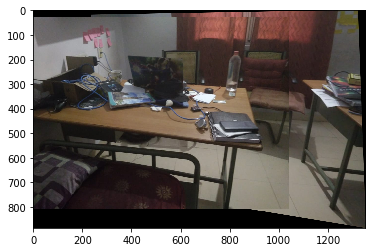

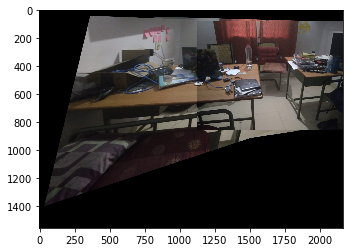

In [138]:
images = readImages(6)
# images = resize(images,10)
s = stitchAll(images,False)
plt.imshow(s)
plt.show()

## Bonus
+ Yes, we can think of an algorithm to handle jumbled order. basic idea is to compute pairwise correlation of the end of one image with the beginning of all images and store the best result of this for every single image. Do the same for the beginning of one image with end of all images. now, the image with lowest best-correlation with its end and the beginning of any other image will be the end of our panaroma. also the image with lowest best-correlation of its beginning with the end of any other image will be start of our panaroma. after this we can construct a chain using the prestored information of successor of each image. This will give us the perfect order. now all we need to do is perform individual image stitching on all the consecutive pairs in the orders. this should give us the panaroma.

+ Yes, i think it is possible to stitch images of different scenes which are noisy without human intervention. but the noise should be below a threshold.
   We can first cluster images of same type using a clustering algorithm like K-means. now, we can perform the above algorithm of part 1 in these individual clusters. using thresholding we can handle the problems arising due to the noisy nature of the images.

+ This being said, if the images are very noisy, it will be not be possible without human intervention as the ordering part might be hampered.